In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

# تأكد انك تستخدم GPU لو موجود
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
class BoneAgeDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.data.iloc[idx, 0])+ ".png")
        image = Image.open(img_path).convert("RGB")
        age = self.data.iloc[idx, 2]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(age, dtype=torch.float32)

# مثال على الـ transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [4]:
train_dataset = BoneAgeDataset(csv_file=r'/kaggle/input/rsna-bone-age/RSNA_Annotations/RSNA_Annotations/BONEAGE/boneage_train.csv', img_dir=r'/kaggle/input/rsna-bone-age/RSNA_train/images', transform=transform)

In [5]:
from torch.utils.data import random_split

# نفترض train_dataset موجود
train_size = int(0.8 * len(train_dataset))  # 80% ترين
val_size = len(train_dataset) - train_size  # 20% فاليديشن

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# دلوقتي نجهز لودرز لكل subset
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)


In [6]:
test_dataset = BoneAgeDataset(csv_file='/kaggle/input/rsna-bone-age/RSNA_Annotations/RSNA_Annotations/BONEAGE/boneage_val.csv', img_dir='/kaggle/input/rsna-bone-age/RSNA_val/images', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch.nn.functional as F

def evaluate(model, test_loader, criterion):
    model.eval()
    total_mae = 0.0
    total_loss = 0.0
    total_samples = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():  # مفيش Backpropagation
        for images, true_ages in test_loader:
            images = images.to(device)
            true_ages = true_ages.to(device)

            outputs = model(images)

            loss = criterion(outputs, true_ages)
            mae = F.l1_loss(outputs, true_ages, reduction='sum')  # L1 loss = MAE

            total_loss += loss.item() * images.size(0)  # لازم نضرب في عدد العينات عشان نحسب المتوسط بعدين
            total_mae += mae.item()
            total_samples += images.size(0)

            all_preds.append(outputs.cpu())
            all_targets.append(true_ages.cpu())

    # بعد اللوب
    avg_loss = total_loss / total_samples
    avg_mae = total_mae / total_samples

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    ss_res = torch.sum((all_targets - all_preds) ** 2)
    ss_tot = torch.sum((all_targets - torch.mean(all_targets)) ** 2)
    r2 = 1 - ss_res / ss_tot

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test MAE: {avg_mae:.2f} years")
    print(f"Test R²: {r2:.4f}")

    return avg_loss, avg_mae, r2

# استخدمها كده
# نفترض ان criterion = torch.nn.MSELoss()

# Google

In [7]:
from transformers import ViTModel

class BoneAgePredictor(nn.Module):
    def __init__(self):
        super(BoneAgePredictor, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.regressor = nn.Linear(self.vit.config.hidden_size, 1)

    def forward(self, x):
        outputs = self.vit(x)
        hidden_state = outputs.last_hidden_state[:, 0]  # CLS token
        age = self.regressor(hidden_state)
        return age.squeeze()  # عشان يطلع رقم مش مصفوفة


2025-05-04 10:47:28.011858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746355648.251409      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746355648.317577      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

🔧 Starting training...
Epoch [1/25] Train Loss: 16355.4704 Val Loss: 14856.9921 Val MAE: 114.33 years Val R²: -7.2881
Epoch [2/25] Train Loss: 13733.4377 Val Loss: 11797.5146 Val MAE: 100.21 years Val R²: -5.5816
Epoch [3/25] Train Loss: 10405.0195 Val Loss: 8479.2199 Val MAE: 82.99 years Val R²: -3.7306
Epoch [4/25] Train Loss: 7166.0650 Val Loss: 5578.4887 Val MAE: 65.48 years Val R²: -2.1123
Epoch [5/25] Train Loss: 4581.2918 Val Loss: 3529.5925 Val MAE: 50.94 years Val R²: -0.9691
Epoch [6/25] Train Loss: 2915.6250 Val Loss: 2394.5679 Val MAE: 41.94 years Val R²: -0.3355
Epoch [7/25] Train Loss: 2081.3220 Val Loss: 1931.2800 Val MAE: 37.39 years Val R²: -0.0767
Epoch [8/25] Train Loss: 1772.0675 Val Loss: 1801.8521 Val MAE: 35.36 years Val R²: -0.0042
Epoch [9/25] Train Loss: 1681.4425 Val Loss: 1778.5390 Val MAE: 34.75 years Val R²: 0.0089
Epoch [10/25] Train Loss: 1663.1551 Val Loss: 1754.2473 Val MAE: 34.41 years Val R²: 0.0225
Epoch [11/25] Train Loss: 1652.2610 Val Loss: 1782.

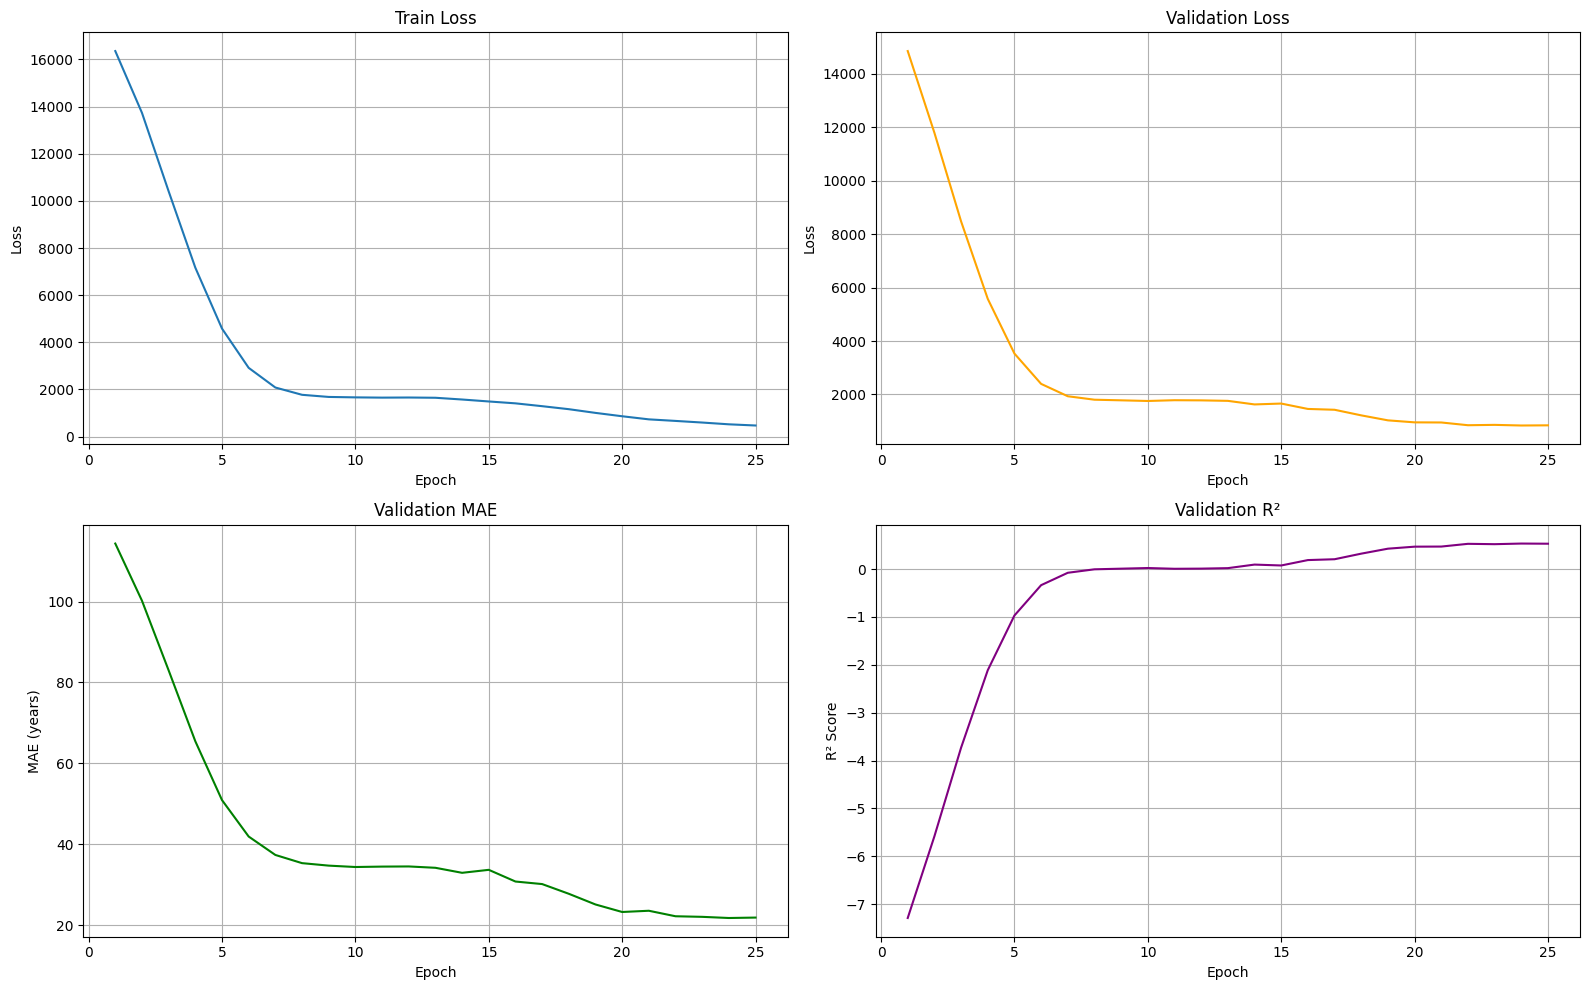

In [8]:
import time
import matplotlib.pyplot as plt

# إنشاء الموديل
model = BoneAgePredictor().to(device)

# إعداد اللوس والأوبتيميزار
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Lists to track metrics
train_losses = []
val_losses = []
val_maes = []
val_r2s = []

# احسب وقت البداية
start_time = time.time()
print("🔧 Starting training...")

# Training with validation
num_epochs = 25

for epoch in range(num_epochs):
    ### Train Phase
    model.train()
    running_loss = 0.0

    for images, ages in train_loader:
        images = images.to(device)
        ages = ages.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, ages)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    ### Validation Phase
    model.eval()
    val_loss = 0.0
    total_mae = 0.0
    total_samples = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, ages in val_loader:
            images = images.to(device)
            ages = ages.to(device)

            outputs = model(images)
            loss = criterion(outputs, ages)

            val_loss += loss.item()
            mae = torch.abs(outputs - ages).sum()
            total_mae += mae.item()
            total_samples += images.size(0)

            all_preds.append(outputs.cpu())
            all_targets.append(ages.cpu())

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    ss_res = torch.sum((all_targets - all_preds) ** 2)
    ss_tot = torch.sum((all_targets - torch.mean(all_targets)) ** 2)
    r2 = 1 - ss_res / ss_tot

    avg_val_loss = val_loss / len(val_loader)
    avg_val_mae = total_mae / total_samples

    # حفظ القيم في Lists للرسم
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_maes.append(avg_val_mae)
    val_r2s.append(r2.item())

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} "
          f"Val Loss: {avg_val_loss:.4f} "
          f"Val MAE: {avg_val_mae:.2f} years "
          f"Val R²: {r2:.4f}")

# وقت الانتهاء
end_time = time.time()
print(f"\n✅ Training finished in {(end_time - start_time)/60:.2f} minutes")

# 📈 الرسم بعد انتهاء التدريب
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs, val_losses, label='Val Loss', color='orange')
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(epochs, val_maes, label='Val MAE', color='green')
plt.title("Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE (years)")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(epochs, val_r2s, label='Val R²', color='purple')
plt.title("Validation R²")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.grid(True)

plt.tight_layout()
plt.show()


In [11]:
import torch.nn.functional as F

def evaluate(model, test_loader, criterion):
    model.eval()
    total_mae = 0.0
    total_loss = 0.0
    total_samples = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():  # مفيش Backpropagation
        for images, true_ages in test_loader:
            images = images.to(device)
            true_ages = true_ages.to(device)

            outputs = model(images)

            loss = criterion(outputs, true_ages)
            mae = F.l1_loss(outputs, true_ages, reduction='sum')  # L1 loss = MAE

            total_loss += loss.item() * images.size(0)  # لازم نضرب في عدد العينات عشان نحسب المتوسط بعدين
            total_mae += mae.item()
            total_samples += images.size(0)

            all_preds.append(outputs.cpu())
            all_targets.append(true_ages.cpu())

    # بعد اللوب
    avg_loss = total_loss / total_samples
    avg_mae = total_mae / total_samples

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    ss_res = torch.sum((all_targets - all_preds) ** 2)
    ss_tot = torch.sum((all_targets - torch.mean(all_targets)) ** 2)
    r2 = 1 - ss_res / ss_tot

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test MAE: {avg_mae:.2f} years")
    print(f"Test R²: {r2:.4f}")

    return avg_loss, avg_mae, r2

# استخدمها كده
# نفترض ان criterion = torch.nn.MSELoss()
evaluate(model, test_loader, criterion)


Test Loss: 823.2636
Test MAE: 21.44 years
Test R²: 0.5267


(823.2635584138569, 21.438328814590186, tensor(0.5267))

In [12]:
torch.save(model.state_dict(), "/kaggle/working/bone_age_google_vit-base-patch16-224.pth")

# Facebook (Meta)

In [13]:
class BoneAgePredictorfb(nn.Module):
    def __init__(self):
        super(BoneAgePredictorfb, self).__init__()
        self.vit = ViTModel.from_pretrained('facebook/deit-small-patch16-224')
        self.regressor = nn.Linear(self.vit.config.hidden_size, 1)

    def forward(self, x):
        outputs = self.vit(x)
        hidden_state = outputs.last_hidden_state[:, 0]  # CLS token
        age = self.regressor(hidden_state)
        return age.squeeze()  # عشان يطلع رقم مش مصفوفة


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/88.3M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at facebook/deit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔧 Starting training...


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Epoch [1/30] Train Loss: 12800.2954 Val Loss: 10693.9255 Val MAE: 94.72 years Val R²: -4.9660
Epoch [2/30] Train Loss: 9302.6635 Val Loss: 7502.4093 Val MAE: 77.38 years Val R²: -3.1857
Epoch [3/30] Train Loss: 6371.1470 Val Loss: 5044.6370 Val MAE: 61.86 years Val R²: -1.8145
Epoch [4/30] Train Loss: 4246.7024 Val Loss: 3390.7021 Val MAE: 49.95 years Val R²: -0.8916
Epoch [5/30] Train Loss: 2884.2191 Val Loss: 2436.0139 Val MAE: 42.30 years Val R²: -0.3587
Epoch [6/30] Train Loss: 2145.5199 Val Loss: 1989.8445 Val MAE: 38.05 years Val R²: -0.1095
Epoch [7/30] Train Loss: 1821.6054 Val Loss: 1831.9216 Val MAE: 35.78 years Val R²: -0.0211
Epoch [8/30] Train Loss: 1699.2880 Val Loss: 1785.6998 Val MAE: 35.04 years Val R²: 0.0049
Epoch [9/30] Train Loss: 1664.6179 Val Loss: 1768.4943 Val MAE: 34.59 years Val R²: 0.0146
Epoch [10/30] Train Loss: 1653.8647 Val Loss: 1763.9183 Val MAE: 34.34 years Val R²: 0.0172
Epoch [11/30] Train Loss: 1620.8860 Val Loss: 1753.0110 Val MAE: 34.56 years Val

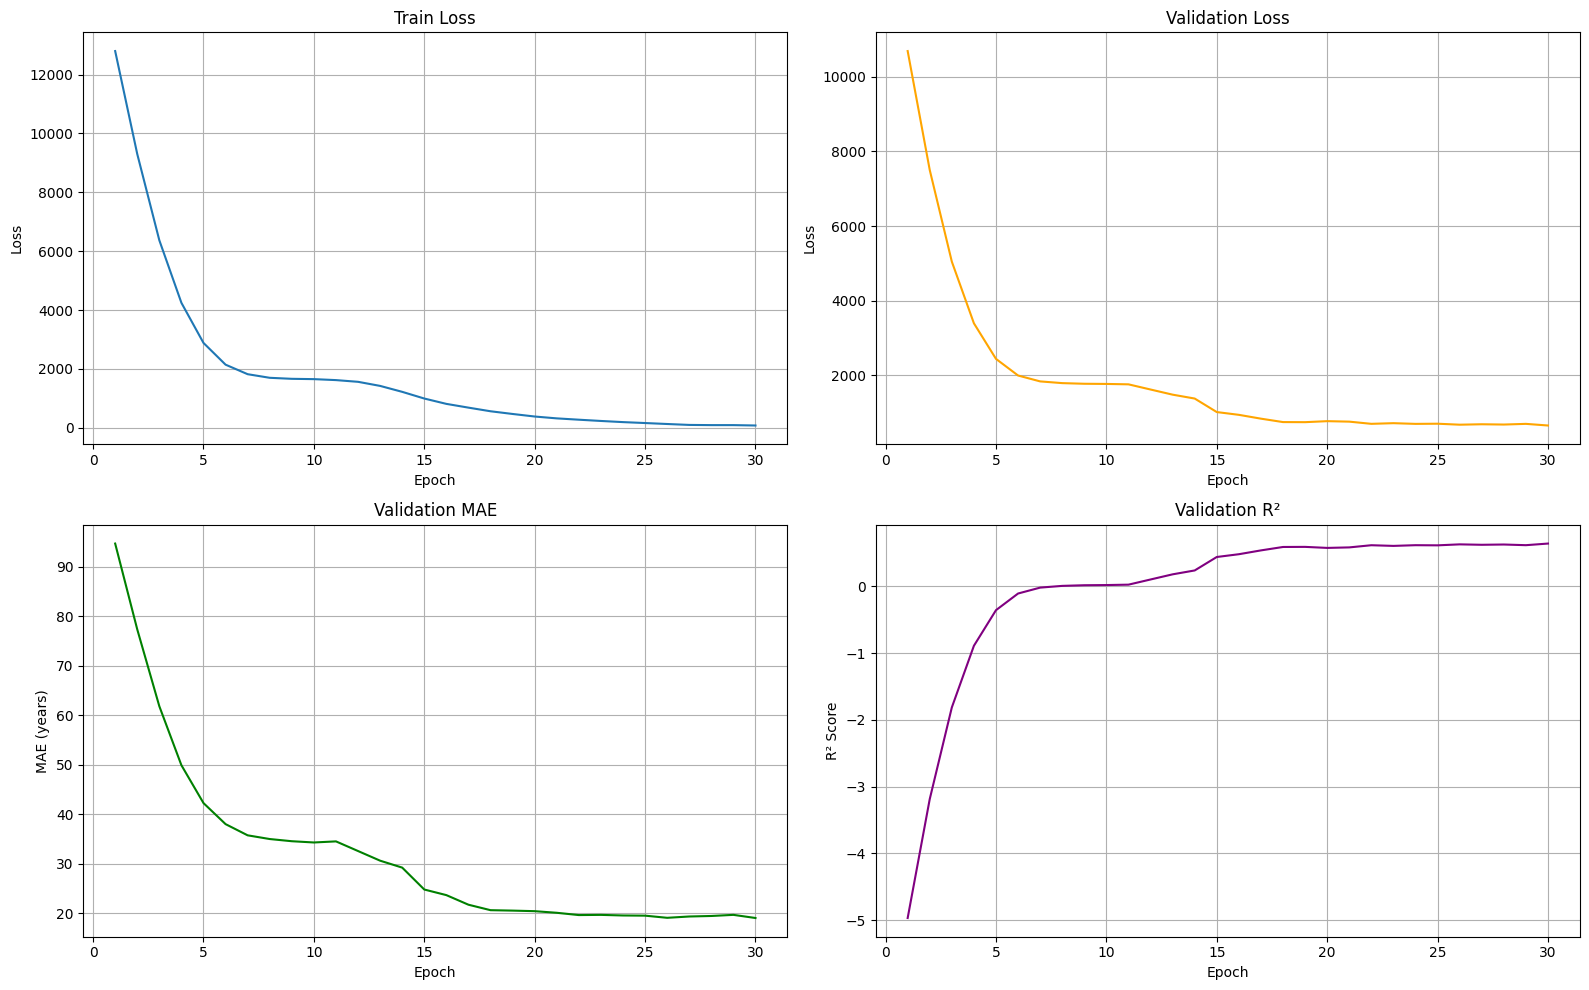

In [14]:
import time
import matplotlib.pyplot as plt

# إنشاء الموديل
modelMeta = BoneAgePredictorfb().to(device)

# إعداد اللوس والأوبتيميزار
criterion = nn.MSELoss()
optimizer = optim.AdamW(modelMeta.parameters(), lr=1e-4)

# Lists to track metrics
train_losses = []
val_losses = []
val_maes = []
val_r2s = []

# احسب وقت البداية
start_time = time.time()
print("🔧 Starting training...")

# Training with validation
num_epochs = 30

for epoch in range(num_epochs):
    ### Train Phase
    modelMeta.train()
    running_loss = 0.0

    for images, ages in train_loader:
        images = images.to(device)
        ages = ages.to(device)

        optimizer.zero_grad()
        outputs = modelMeta(images)
        loss = criterion(outputs, ages)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    ### Validation Phase
    modelMeta.eval()
    val_loss = 0.0
    total_mae = 0.0
    total_samples = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, ages in val_loader:
            images = images.to(device)
            ages = ages.to(device)

            outputs = modelMeta(images)
            loss = criterion(outputs, ages)

            val_loss += loss.item()
            mae = torch.abs(outputs - ages).sum()
            total_mae += mae.item()
            total_samples += images.size(0)

            all_preds.append(outputs.cpu())
            all_targets.append(ages.cpu())

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    ss_res = torch.sum((all_targets - all_preds) ** 2)
    ss_tot = torch.sum((all_targets - torch.mean(all_targets)) ** 2)
    r2 = 1 - ss_res / ss_tot

    avg_val_loss = val_loss / len(val_loader)
    avg_val_mae = total_mae / total_samples

    # حفظ القيم في Lists للرسم
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_maes.append(avg_val_mae)
    val_r2s.append(r2.item())

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} "
          f"Val Loss: {avg_val_loss:.4f} "
          f"Val MAE: {avg_val_mae:.2f} years "
          f"Val R²: {r2:.4f}")

# وقت الانتهاء
end_time = time.time()
print(f"\n✅ Training finished in {(end_time - start_time)/60:.2f} minutes")

# 📈 الرسم بعد انتهاء التدريب
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs, val_losses, label='Val Loss', color='orange')
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(epochs, val_maes, label='Val MAE', color='green')
plt.title("Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE (years)")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(epochs, val_r2s, label='Val R²', color='purple')
plt.title("Validation R²")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.grid(True)

plt.tight_layout()
plt.show()


In [15]:
evaluate(modelMeta, test_loader, criterion)

Test Loss: 593.2520
Test MAE: 18.28 years
Test R²: 0.6590


(593.2519833427563, 18.27725082665159, tensor(0.6590))

In [16]:
torch.save(modelMeta.state_dict(), "/kaggle/working/bone_age_facebook_deit-small-patch16.pth")

# Microsoft

In [17]:
from transformers import ViTModel

class BoneAgePredictorMC(nn.Module):
    def __init__(self):
        super(BoneAgePredictorMC, self).__init__()
        self.vit = ViTModel.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
        self.regressor = nn.Linear(self.vit.config.hidden_size, 1)

    def forward(self, x):
        outputs = self.vit(x)
        hidden_state = outputs.last_hidden_state[:, 0]  # CLS token
        age = self.regressor(hidden_state)
        return age.squeeze()  # عشان يطلع رقم مش مصفوفة


In [18]:
import time
import matplotlib.pyplot as plt

# إنشاء الموديل
modelmc = BoneAgePredictorMC().to(device)

# إعداد اللوس والأوبتيميزار
criterion = nn.MSELoss()
optimizer = optim.AdamW(modelmc.parameters(), lr=1e-4)

# Lists to track metrics
train_losses = []
val_losses = []
val_maes = []
val_r2s = []

# احسب وقت البداية
start_time = time.time()
print("🔧 Starting training...")

# Training with validation
num_epochs = 30

for epoch in range(num_epochs):
    ### Train Phase
    modelmc.train()
    running_loss = 0.0

    for images, ages in train_loader:
        images = images.to(device)
        ages = ages.to(device)

        optimizer.zero_grad()
        outputs = modelmc(images)
        loss = criterion(outputs, ages)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    ### Validation Phase
    modelmc.eval()
    val_loss = 0.0
    total_mae = 0.0
    total_samples = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, ages in val_loader:
            images = images.to(device)
            ages = ages.to(device)

            outputs = modelmc(images)
            loss = criterion(outputs, ages)

            val_loss += loss.item()
            mae = torch.abs(outputs - ages).sum()
            total_mae += mae.item()
            total_samples += images.size(0)

            all_preds.append(outputs.cpu())
            all_targets.append(ages.cpu())

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    ss_res = torch.sum((all_targets - all_preds) ** 2)
    ss_tot = torch.sum((all_targets - torch.mean(all_targets)) ** 2)
    r2 = 1 - ss_res / ss_tot

    avg_val_loss = val_loss / len(val_loader)
    avg_val_mae = total_mae / total_samples

    # حفظ القيم في Lists للرسم
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_maes.append(avg_val_mae)
    val_r2s.append(r2.item())

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} "
          f"Val Loss: {avg_val_loss:.4f} "
          f"Val MAE: {avg_val_mae:.2f} years "
          f"Val R²: {r2:.4f}")

# وقت الانتهاء
end_time = time.time()
print(f"\n✅ Training finished in {(end_time - start_time)/60:.2f} minutes")

# 📈 الرسم بعد انتهاء التدريب
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs, val_losses, label='Val Loss', color='orange')
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(epochs, val_maes, label='Val MAE', color='green')
plt.title("Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE (years)")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(epochs, val_r2s, label='Val R²', color='purple')
plt.title("Validation R²")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.grid(True)

plt.tight_layout()
plt.show()


config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

You are using a model of type beit to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/414M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/414M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized: ['embeddings.cls_token', 'embeddings.patch_embeddings.projection.bias', 'embeddings.patch_embeddings.projection.weight', 'embeddings.position_embeddings', 'encoder.layer.0.attention.attention.key.bias', 'encoder.layer.0.attention.attention.key.weight', 'encoder.layer.0.attention.attention.query.bias', 'encoder.layer.0.attention.attention.query.weight', 'encoder.layer.0.attention.attention.value.bias', 'encoder.layer.0.attention.attention.value.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.layernorm_after.bias', 'encoder.layer.0.layernorm_after.weight', 'encoder.layer.0.layernorm_before.bias', 'encoder.layer.0.layernorm_before.weight', 'encoder.layer.0.output.dense.bias', 'encoder.l

🔧 Starting training...


KeyboardInterrupt: 

In [ ]:
evaluate(modelmc, test_loader, criterion)

In [ ]:
torch.save(modelmc.state_dict(), "/kaggle/working/bone_age_microsoft_beit-base-patch16-224.pth")